In [1]:
"""most figures were created by this notebook. We both trained models individually for comparison but i wrote the second part of the report.
"""



import kagglehub
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# Download latest version
path = kagglehub.dataset_download("uom190346a/global-coffee-health-dataset")
csv_file = os.path.join(path, "synthetic_coffee_health_10000.csv")
data = pd.read_csv(csv_file)


data.head()

,ID,Age,Gender,Country,Coffee_Intake,Caffeine_mg,Sleep_Hours,Sleep_Quality,BMI,Heart_Rate,Stress_Level,Physical_Activity_Hours,Health_Issues,Occupation,Smoking,Alcohol_Consumption
0,1,40,Male,Germany,3.5,328.1,7.5,Good,24.9,78,Low,14.5,NaN,Other,0,0
1,2,33,Male,Germany,1.0,94.1,6.2,Good,20.0,67,Low,11.0,NaN,Service,0,0
2,3,42,Male,Brazil,5.3,503.7,5.9,Fair,22.7,59,Medium,11.2,Mild,Office,0,0
3,4,53,Male,Germany,2.6,249.2,7.3,Good,24.7,71,Low,6.6,Mild,Other,0,0
4,5,32,Female,Spain,3.1,298.0,5.3,Fair,24.1,76,Medium,8.5,Mild,Student,0,1


In [2]:
#start with the visualization
#smoking and alcohol are boolean
#Gender Country and Sleep quality must be converted to numerals
"""Country could be hard to convert maybe we just sort them by GDP and give them descending numbers based on that or we use an index measuring health care. Coffee intake and estimated caffeine is redundent """
data.info()
data.describe()
#remove NaNs
data["Health_Issues"] = data["Health_Issues"].fillna("nichts")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       10000 non-null  int64  
 1   Age                      10000 non-null  int64  
 2   Gender                   10000 non-null  object 
 3   Country                  10000 non-null  object 
 4   Coffee_Intake            10000 non-null  float64
 5   Caffeine_mg              10000 non-null  float64
 6   Sleep_Hours              10000 non-null  float64
 7   Sleep_Quality            10000 non-null  object 
 8   BMI                      10000 non-null  float64
 9   Heart_Rate               10000 non-null  int64  
 10  Stress_Level             10000 non-null  object 
 11  Physical_Activity_Hours  10000 non-null  float64
 12  Health_Issues            4059 non-null   object 
 13  Occupation               10000 non-null  object 
 14  Smoking                

In [3]:
# 1. Get unique values (including NaN)
unique_values = data['Health_Issues'].unique()
print("Unique values (including NaN):", unique_values)

# 2. Get counts of each unique value (including NaN)
value_counts = data['Health_Issues'].value_counts(dropna=False)

# 3. Iterate and print
print("\nCounts of each unique value:")
for val in unique_values:
    count = value_counts.get(val, 0)  # .get handles NaN keys properly
    print(f"{val}: {count}")

Unique values (including NaN): ['nichts' 'Mild' 'Moderate' 'Severe']

Counts of each unique value:
nichts: 5941
Mild: 3579
Moderate: 463
Severe: 17


In [4]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder

label_map1 = {"Poor": 0, "Fair": 1, "Good": 2, "Excellent": 3}      #Sleep_Quality
label_map2 = {"nichts": 0, "Mild": 1, "Moderate": 2, "Severe": 3}        #Health_Issues
label_map3 = {"Low": 0, "Medium": 1, "High": 2}                 #Stress_Level
label_map4 = {"Male": 0, "Female": 1, "Other": 2}       #Gender

data["Sleep_Quality"] = data["Sleep_Quality"].map(label_map1)
data["Health_Issues"] = data["Health_Issues"].map(label_map2)
data["Stress_Level"] = data["Stress_Level"].map(label_map3)
data["Gender"] = data["Gender"].map(label_map4)



# Apply label encoding to categorical column
label_encoder = LabelEncoder()

non_number = data.select_dtypes(exclude=["number"]).columns

for i in non_number:
    print(i)
    data[i] = label_encoder.fit_transform(data[i])
    print(label_encoder.classes_)


Country
['Australia' 'Belgium' 'Brazil' 'Canada' 'China' 'Finland' 'France'
 'Germany' 'India' 'Italy' 'Japan' 'Mexico' 'Netherlands' 'Norway'
 'South Korea' 'Spain' 'Sweden' 'Switzerland' 'UK' 'USA']
Occupation
['Healthcare' 'Office' 'Other' 'Service' 'Student']


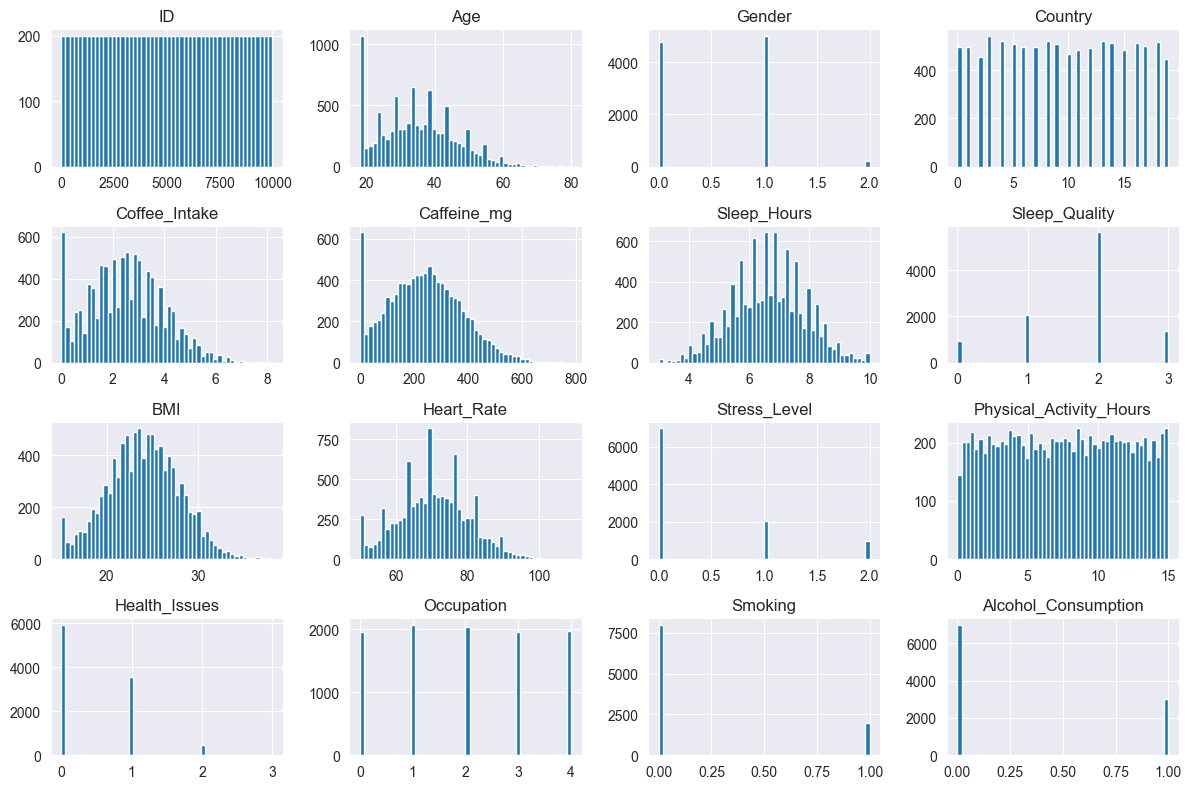

In [5]:
data.hist(bins=50, figsize=(12, 8))
plt.tight_layout()

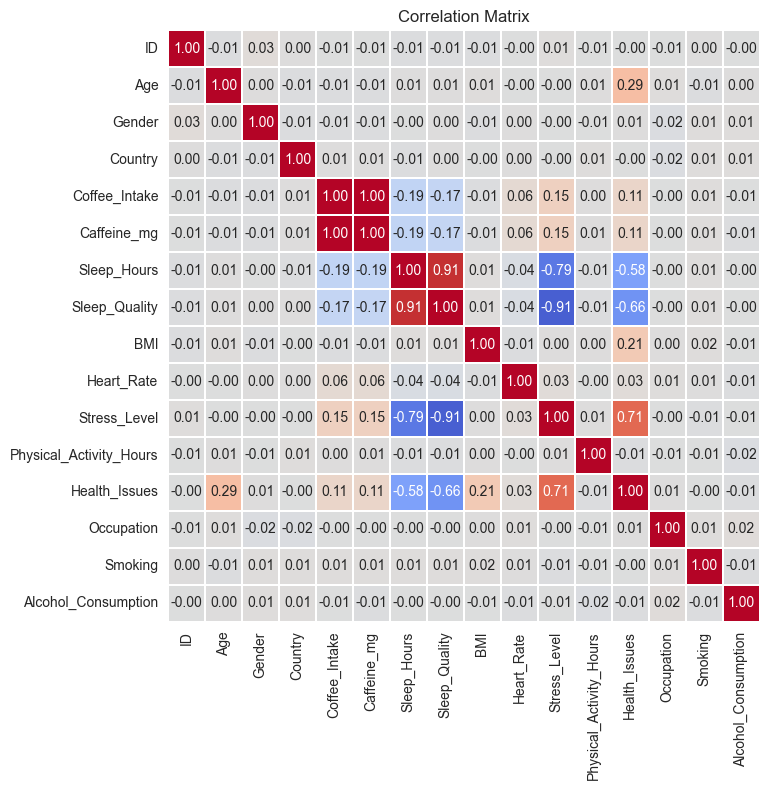

In [6]:
corr = data.corr(numeric_only=True)

# Show heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr,
            annot=True, fmt=".2f",
            vmax=1.0, vmin=-1.0,
            linewidths=0.1,
            cmap="coolwarm",
            cbar=False,
            square=True)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

Based on the correlation matrix, we can drop the features "Occupation", "Gender", "Country", "Alcohol", "Smoking" and "Physical Activity", since they are fully uncorrelated with all the other other features except themselve.

Furthermore, "Coffee" seems to be equivalent to "Caffeine intake", no surprise, so we can drop one of them as well.

Note: Between "Country" and "Smoking" seems to be a slight correlation, but nothing note worthy.

Possible Targets: "Health", "Sleep", "Sleep Hours"

In [7]:
#split data for later use only drop Health issues and ID

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import randint, uniform
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.metrics import (
    accuracy_score, recall_score, classification_report, confusion_matrix
)
from sklearn.metrics import make_scorer, recall_score
import os

# ============================================================
# 1. Split data and select numeric features
# ============================================================
train_df, val_df = train_test_split(
    data.copy(),
    test_size=0.3,
    random_state=42,
    stratify=data["Health_Issues"]
)

"""feature_names = train_df.select_dtypes(include=["number"]).drop(
    columns=["Health_Issues"]
).columns"""


feature_names = train_df.select_dtypes(include=["number"]).drop(columns=["Health_Issues", "ID"]).columns


X_train = train_df[feature_names].values
y_train = train_df["Health_Issues"].values
X_val = val_df[feature_names].values
y_val = val_df["Health_Issues"].values



              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1782
           1       1.00      1.00      1.00      1074
           2       0.96      0.99      0.98       139
           3       1.00      1.00      1.00         5

    accuracy                           1.00      3000
   macro avg       0.99      1.00      0.99      3000
weighted avg       1.00      1.00      1.00      3000



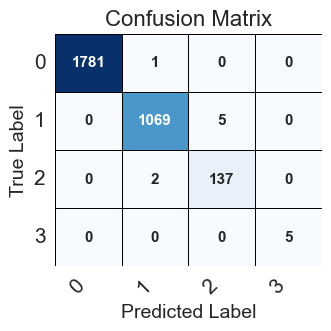

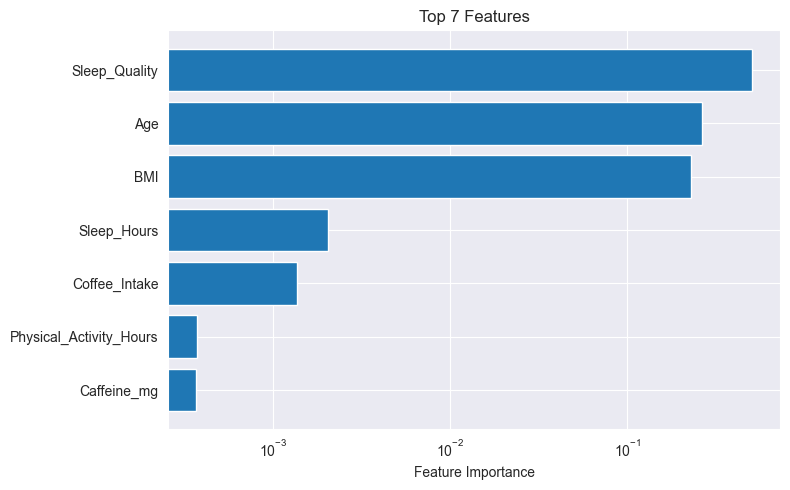

depth: 9


In [8]:
#First naive fit of a decision tree

pipeline = Pipeline([
    #("scaler", StandardScaler()),
    ("tree", DecisionTreeClassifier(
    criterion='gini',
    splitter='best',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=None,
    random_state=42,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    class_weight=None,

))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
print(classification_report(y_val, y_pred))
conf_matrix_tree_naive = confusion_matrix(y_val, y_pred)
labels = [str(c) for c in np.unique(y_train)]


plt.figure(figsize=(3.2, 3.2))  # smaller overall figure (A4-friendly)

sns.heatmap(
    conf_matrix_tree_naive,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels,
    cbar=False,
    linewidths=0.6,
    linecolor="black",
    annot_kws={"size": 11, "weight": "bold"}  # larger, readable numbers
)

plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.title("Confusion Matrix", fontsize=16, pad=6)
plt.xticks(fontsize=15, rotation=45, ha="right")
plt.yticks(fontsize=15, rotation=0)

plt.tight_layout(pad=0.3)
plt.savefig("confusion_matrix_dec_tree_naive.pdf", dpi=300, bbox_inches="tight")
plt.show()

# ============================================================
# 6. Feature importances
# ============================================================
importances = pipeline.named_steps["tree"].feature_importances_
indices = importances.argsort()[::-1][:7]

plt.figure(figsize=(8, 5))
plt.barh(range(len(indices)), importances[indices][::-1], align="center", log=True)
plt.yticks(range(len(indices)), [feature_names[i] for i in indices[::-1]])
plt.xlabel("Feature Importance")
plt.title("Top 7 Features")
plt.tight_layout()
#plt.savefig("importances.pdf")
plt.show()


print("depth:",  pipeline.named_steps["tree"].get_depth() )

In [9]:

# ============================================================
# 2. Build pipeline and hyperparameter search space
# ============================================================
pipeline = Pipeline([
    #("scaler", StandardScaler()),
    ("tree", DecisionTreeClassifier(random_state=42))
])

param_distributions = {
    #'tree__criterion': ['gini'],
    #'tree__splitter': ['best'],
    'tree__max_depth': randint(7, 10),
    'tree__min_samples_split': randint(2, 10),
    'tree__min_samples_leaf': randint(1, 8),
    #'tree__min_weight_fraction_leaf': uniform(0.0, 0.5),
    #'tree__max_features': [None, 'sqrt', 'log2'],
    #'tree__max_leaf_nodes': [None] + list(range(5, 50, 5)),
    #'tree__min_impurity_decrease': uniform(0.0, 0.1),
    #'tree__ccp_alpha': uniform(0.0, 0.05)
}

search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=100,
    cv=10,
    scoring ="accuracy",
    n_jobs=-1,
    random_state=42
)

# ============================================================
# 3. Fit search & get best model
# ============================================================
search.fit(X_train, y_train)
best_model = search.best_estimator_

y_pred = best_model.predict(X_val)

print("Best Parameters from RandomizedSearchCV:", search.best_params_)
print(f"\nAccuracy: {accuracy_score(y_val, y_pred):.3f}")
print(f"Sensitivity (macro recall): {recall_score(y_val, y_pred, average='macro'):.3f}\n")
print(classification_report(y_val, y_pred))

# ============================================================
# 4. Confusion matrix
# ============================================================
conf_matrix = confusion_matrix(y_val, y_pred)
labels = [str(c) for c in np.unique(y_train)]



Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /var/folders/fr/29kq_rz95c59455clpg67vvm0000gn/T/joblib_memmapping_folder_25035_3b4bf7a27d8f4526aa0249ed371d13e2_aacb8b9584444db4a58d54eb365fb55b for automatic cleanup: unknown resource type folder
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /loky-25035-zkqaanqm for automatic cleanup: unknown resource type semlock
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/

Best Parameters from RandomizedSearchCV: {'tree__max_depth': 8, 'tree__min_samples_leaf': 2, 'tree__min_samples_split': 9}

Accuracy: 0.997
Sensitivity (macro recall): 0.995

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1782
           1       1.00      1.00      1.00      1074
           2       0.96      0.99      0.98       139
           3       1.00      1.00      1.00         5

    accuracy                           1.00      3000
   macro avg       0.99      1.00      0.99      3000
weighted avg       1.00      1.00      1.00      3000



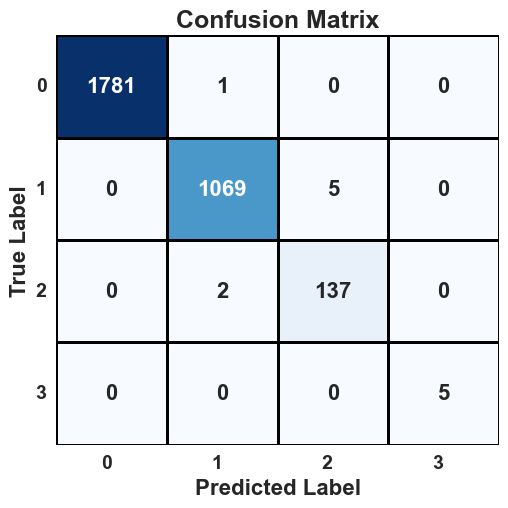

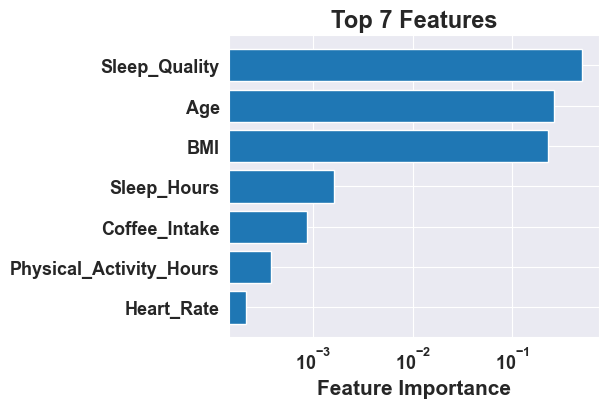

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ============================================================
# 5. Confusion matrix with larger fonts
# ============================================================
plt.figure(figsize=(5, 5))  # slightly smaller but high readability

sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels,
    cbar=False,
    linewidths=1,
    linecolor="black",
    annot_kws={"size": 16, "weight": "bold"}  # big, bold numbers inside cells
)

plt.xlabel("Predicted Label", fontsize=16, fontweight="bold")
plt.ylabel("True Label", fontsize=16, fontweight="bold")
plt.title("Confusion Matrix", fontsize=18, pad=6, fontweight="bold")
plt.xticks(fontsize=14, rotation=0, ha="right", fontweight="bold")
plt.yticks(fontsize=14, rotation=0, fontweight="bold")

plt.tight_layout(pad=0.4)
plt.savefig("confusion_matrix.pdf", dpi=400, bbox_inches="tight")
plt.show()

# ============================================================
# 6. Feature importances (large, readable fonts)
# ============================================================
importances = best_model.named_steps["tree"].feature_importances_
indices = importances.argsort()[::-1][:7]

plt.figure(figsize=(6, 4))
plt.barh(
    range(len(indices)),
    importances[indices][::-1],
    align="center",
    log=True
)

plt.yticks(
    range(len(indices)),
    [feature_names[i] for i in indices[::-1]],
    fontsize=13,
    fontweight="bold"
)
plt.xlabel("Feature Importance", fontsize=15, fontweight="bold")
plt.title("Top 7 Features", fontsize=17, fontweight="bold", pad=6)
plt.xticks(fontsize=13, fontweight="bold")

plt.tight_layout(pad=0.4)
plt.savefig("importances.pdf", dpi=400, bbox_inches="tight")
plt.show()

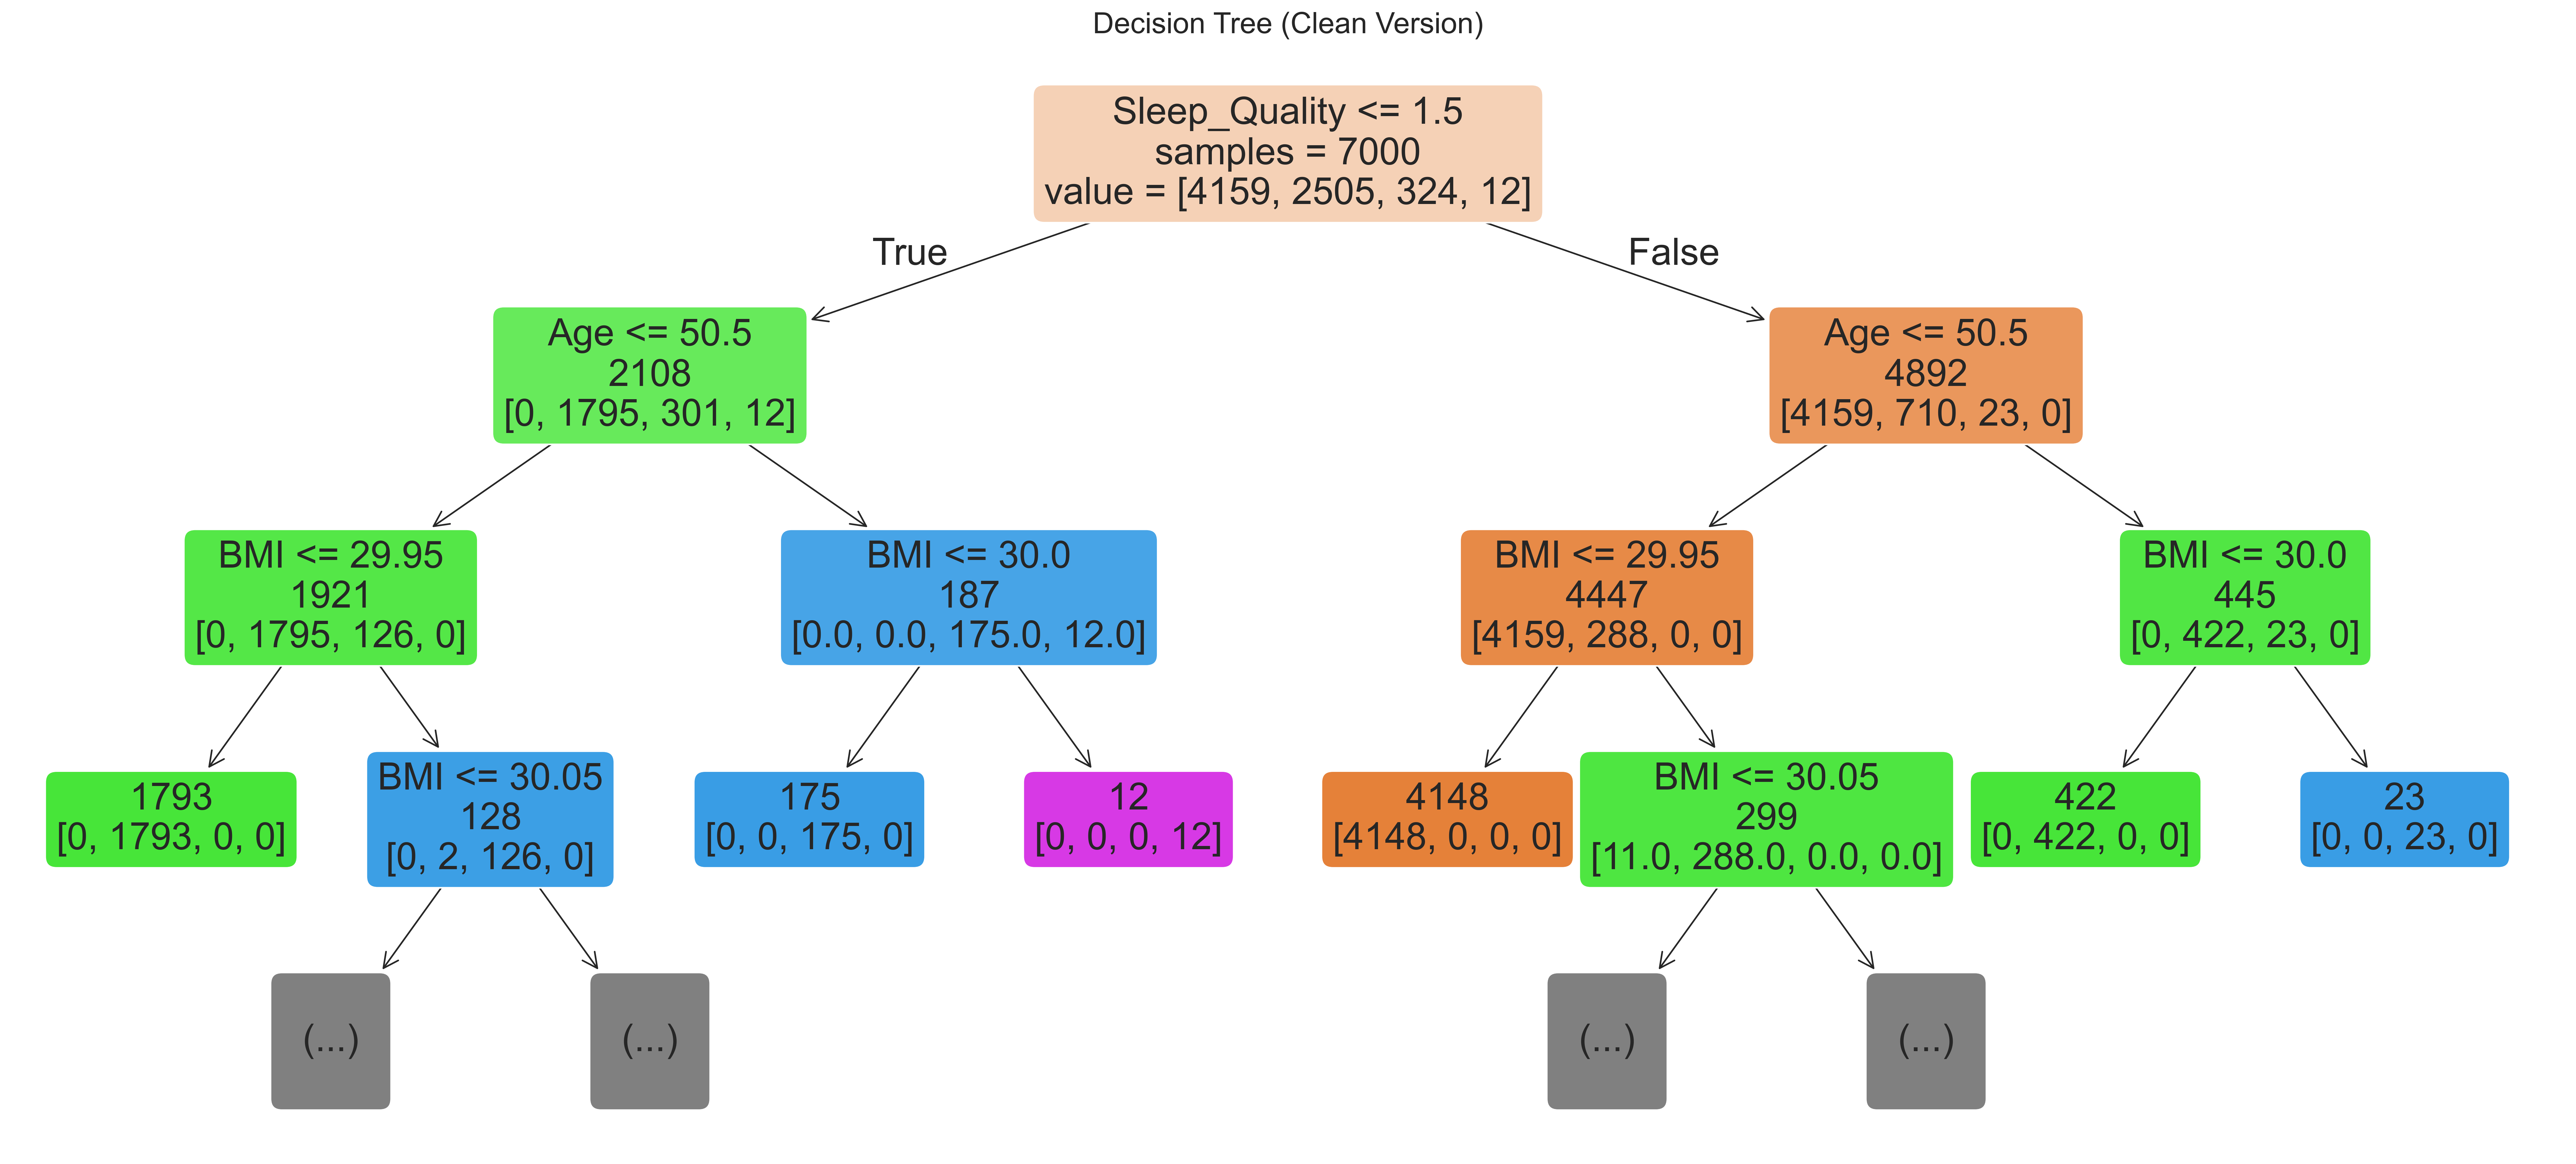

In [11]:

# ============================================================
# 5. Plot decision tree
# ============================================================
tree_model = best_model.named_steps["tree"]

plt.figure(figsize=(22, 10), dpi=400)  # high-res
plot_tree(
    tree_model,
    feature_names=feature_names,
    class_names=None,  # don't show class names
    filled=True,
    rounded=True,
    max_depth=3,       # adjust for readability
    fontsize=23,       # bigger text
    impurity=False,    # remove gini/entropy info
    proportion=False,  # remove class proportions
    label='root'       # only show predicted value at each node
)
plt.title("Decision Tree (Clean Version)", fontsize=18)
plt.tight_layout()
plt.savefig("decision_tree.pdf", dpi=400)
plt.show()




Best Parameters from RandomizedSearchCV:
{'tree__max_depth': 8, 'tree__min_samples_leaf': 2, 'tree__min_samples_split': 9}

Accuracy: 0.996
Macro Recall: 0.845

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1782
           1       1.00      0.99      1.00      1074
           2       0.94      0.99      0.96       139
           3       1.00      0.40      0.57         5

    accuracy                           1.00      3000
   macro avg       0.99      0.84      0.88      3000
weighted avg       1.00      1.00      1.00      3000



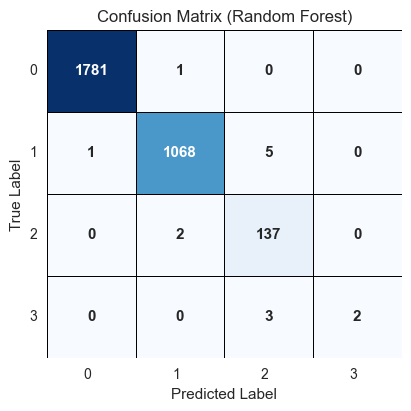

In [12]:
#initial random forest without tuning
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import (
    accuracy_score, recall_score, classification_report, confusion_matrix
)


rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),               # Standardisierung der Features
    ('rf', RandomForestClassifier())            # Random Forest mit Standardparametern
])
# ============================================================
# 4. Fit and evaluate best model
# ============================================================
rf_pipeline.fit(X_train, y_train)


print("\nBest Parameters from RandomizedSearchCV:")
print(search.best_params_)

# Predict on validation set
y_pred = rf_pipeline.predict(X_val)

# Evaluation
print(f"\nAccuracy: {accuracy_score(y_val, y_pred):.3f}")
print(f"Macro Recall: {recall_score(y_val, y_pred, average='macro'):.3f}\n")
print(classification_report(y_val, y_pred))


conf_matrix_rf = confusion_matrix(y_val, y_pred)
labels = [str(c) for c in np.unique(y_train)]

plt.figure(figsize=(4, 4))  # compact, fits a single A4 column nicely

sns.heatmap(
    conf_matrix_rf,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels,
    cbar=False,
    linewidths=0.6,
    linecolor="black",
    annot_kws={"size": 11, "weight": "bold"}  # readable numbers
)

plt.xlabel("Predicted Label", fontsize=11)
plt.ylabel("True Label", fontsize=11)
plt.title("Confusion Matrix (Random Forest)", fontsize=12, pad=6)
plt.xticks(fontsize=10, rotation=0, ha="right")
plt.yticks(fontsize=10, rotation=0)

plt.tight_layout(pad=0.3)
plt.savefig("confusion_matrix_rand_for.pdf", dpi=300, bbox_inches="tight")
plt.show()



In [13]:
"""Code for the finetuning of the model"""
# ============================================================
# 1. Define pipeline
# ============================================================

r_for_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("forest", RandomForestClassifier(
        bootstrap=True,
        random_state=42,
        class_weight='balanced'
    ))
])

# ============================================================
# 2. Define hyperparameter search space
# ============================================================
param_distributions = {
    "forest__n_estimators": randint(50, 200),          # number of trees
    "forest__max_depth": randint(5, 25),               # tree depth
    "forest__min_samples_split": randint(2, 10),
    "forest__min_samples_leaf": randint(1, 10),
    #"forest__max_features": ['sqrt', 'log2', None],    # feature subset size
    #"forest__bootstrap": [True, False]
}

# ============================================================
# 3. Randomized search with cross-validation
# ============================================================
search = RandomizedSearchCV(
    estimator=r_for_pipeline,
    param_distributions=param_distributions,
    n_iter=100,  # number of parameter settings to try
    cv=5,       # 5-fold cross-validation
    scoring='accuracy',  # treat all classes equally
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# ============================================================
# 4. Fit and evaluate best model
# ============================================================
search.fit(X_train, y_train)
best_model = search.best_estimator_

print("\nBest Parameters from RandomizedSearchCV:")
print(search.best_params_)

# Predict on validation set
y_pred = best_model.predict(X_val)

# Evaluation
print(f"\nAccuracy: {accuracy_score(y_val, y_pred):.3f}")
print(f"Macro Recall: {recall_score(y_val, y_pred, average='macro'):.3f}\n")
print(classification_report(y_val, y_pred))

# ============================================================
# 5. Confusion matrix
# ============================================================


Fitting 5 folds for each of 100 candidates, totalling 500 fits


Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /var/folders/fr/29kq_rz95c59455clpg67vvm0000gn/T/joblib_memmapping_folder_25035_c492e0217de44d7abc332cc6a3bf779e_a6d36d26028a4a54a6c1b6207ffb2e08 for automatic cleanup: unknown resource type folder
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /var/folders/fr/29kq_rz95c59455clpg67vvm0000gn/T/joblib_memmapping_folder_25035_3b4bf7a27d8f4526aa0249ed371d13e2_3a8c800bc6c74c9f81563103bf77e3a0 for automatic cleanup: unk


Best Parameters from RandomizedSearchCV:
{'forest__max_depth': 9, 'forest__min_samples_leaf': 1, 'forest__min_samples_split': 8, 'forest__n_estimators': 109}

Accuracy: 0.996
Macro Recall: 0.845

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1782
           1       1.00      1.00      1.00      1074
           2       0.94      0.99      0.96       139
           3       1.00      0.40      0.57         5

    accuracy                           1.00      3000
   macro avg       0.99      0.84      0.88      3000
weighted avg       1.00      1.00      1.00      3000



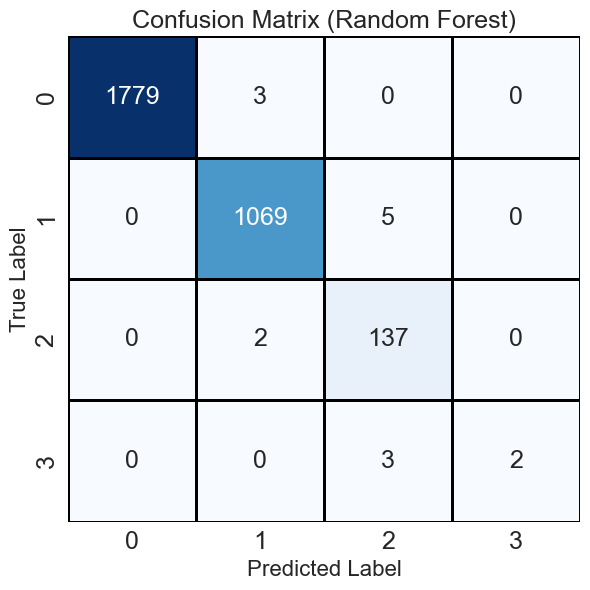

In [14]:
#confusion matrix for the finetuned random forest
conf_matrix = confusion_matrix(y_val, y_pred)
labels = [str(c) for c in np.unique(y_train)]

plt.figure(figsize=(6, 6))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels,
    cbar=False,
    linewidths=1,
    linecolor="black",
    annot_kws={"size": 18},     # increase number size inside boxes
)

plt.xlabel("Predicted Label", fontsize=16)
plt.ylabel("True Label", fontsize=16)
plt.title("Confusion Matrix (Random Forest)", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.savefig("confusion_matrix_rand_for.pdf")
plt.show()

In [15]:
print(X_train.shape)

(7000, 14)


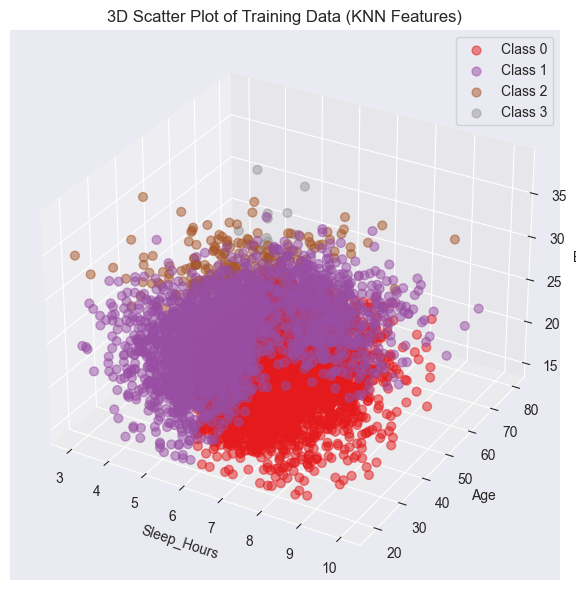

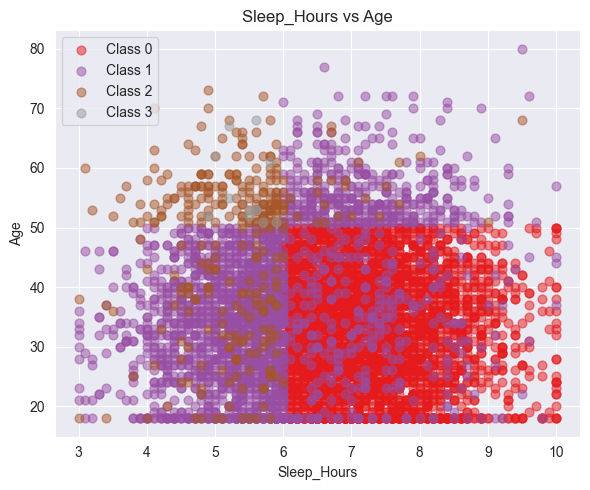

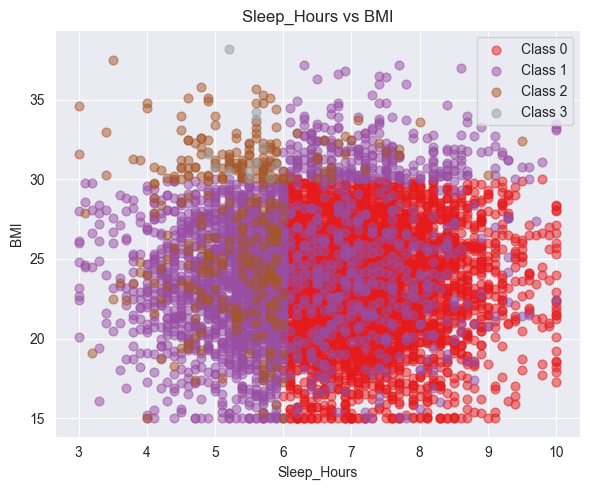

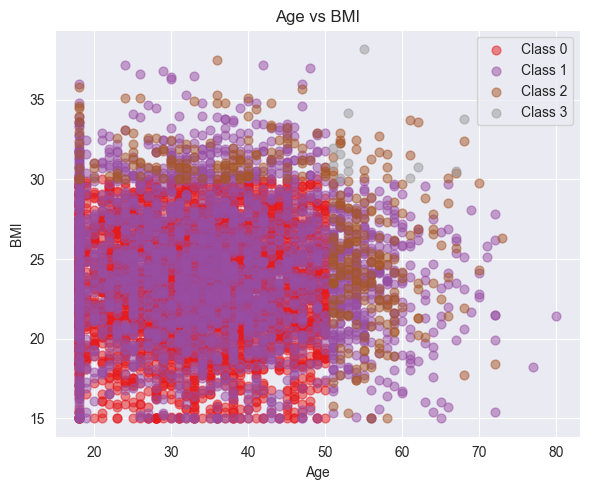

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from mpl_toolkits.mplot3d import Axes3D  # for 3D plotting

# --------------------------
# FEATURE SELECTION
# --------------------------
train_knn = train_df.copy()
val_knn = val_df.copy()

# Select only the features you want for training
feature_names_knn = ["Sleep_Hours", "Age", "BMI"]

X_train_knn = train_knn[feature_names_knn].values
y_train_knn = train_knn["Health_Issues"].values

X_val_knn = val_knn[feature_names_knn].values
y_val_knn = val_knn["Health_Issues"].values

# --------------------------
# PIPELINE SETUP
# --------------------------
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(
        n_neighbors=5,
        weights='uniform',
        algorithm='auto',
        leaf_size=30,
        p=2,
        metric='minkowski',
        metric_params=None,
        n_jobs=None
    ))
])

# --------------------------
# TRAIN AND PREDICT
# --------------------------
# Example: knn_pipeline.fit(X_train_knn, y_train_knn)
# y_pred_knn = knn_pipeline.predict(X_val_knn)

# --------------------------
# PLOT SETTINGS
# --------------------------
colors_knn = plt.cm.Set1(np.linspace(0, 1, len(np.unique(y_train_knn))))
alpha_value_knn = 0.5  # Reduced opacity

# --------------------------
# 3D SCATTER PLOT
# --------------------------
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

for idx, label in enumerate(np.unique(y_train_knn)):
    mask = y_train_knn == label
    ax.scatter(
        X_train_knn[mask, 0],
        X_train_knn[mask, 1],
        X_train_knn[mask, 2],
        color=colors_knn[idx],
        label=f'Class {label}',
        s=40,
        alpha=alpha_value_knn
    )

ax.set_xlabel('Sleep_Hours')
ax.set_ylabel('Age')
ax.set_zlabel('BMI')
ax.set_title('3D Scatter Plot of Training Data (KNN Features)')
ax.legend()
plt.tight_layout()
plt.show()

# --------------------------
# 2D SCATTER PLOTS FOR EACH PAIR
# --------------------------
pairs_knn = [(0, 1), (0, 2), (1, 2)]  # index pairs for features

for i, (a, b) in enumerate(pairs_knn):
    plt.figure(figsize=(6, 5))
    for idx, label in enumerate(np.unique(y_train_knn)):
        mask = y_train_knn == label
        plt.scatter(
            X_train_knn[mask, a],
            X_train_knn[mask, b],
            color=colors_knn[idx],
            label=f'Class {label}',
            s=40,
            alpha=alpha_value_knn
        )
    plt.xlabel(feature_names_knn[a])
    plt.ylabel(feature_names_knn[b])
    plt.title(f'{feature_names_knn[a]} vs {feature_names_knn[b]}')
    plt.legend()
    plt.tight_layout()
    plt.show()

Accuracy: 0.964
Sensitivity (macro recall): 0.873

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1782
           1       0.94      0.96      0.95      1074
           2       0.94      0.75      0.83       139
           3       1.00      0.80      0.89         5

    accuracy                           0.96      3000
   macro avg       0.96      0.87      0.91      3000
weighted avg       0.96      0.96      0.96      3000



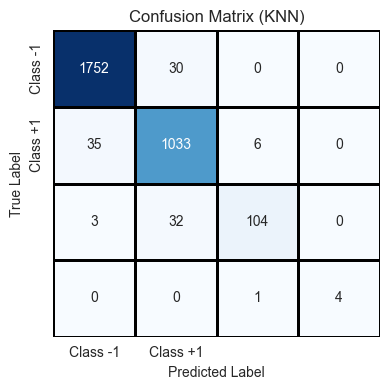

In [17]:
# --- TRAIN AND PREDICT ---
knn_pipeline.fit(X_train_knn, y_train_knn)
y_pred_knn = knn_pipeline.predict(X_val_knn)

# --- Print metrics ---
from sklearn.metrics import accuracy_score, recall_score, classification_report, confusion_matrix
import seaborn as sns

print(f"Accuracy: {accuracy_score(y_val_knn, y_pred_knn):.3f}")
print(f"Sensitivity (macro recall): {recall_score(y_val_knn, y_pred_knn, average='macro'):.3f}\n")
print(classification_report(y_val_knn, y_pred_knn))

# --- Confusion Matrix ---
conf_matrix_knn = confusion_matrix(y_val_knn, y_pred_knn)
labels_knn = ["Class -1", "Class +1"]  # adjust to your actual class labels if needed

plt.figure(figsize=(4, 4))
sns.heatmap(
    conf_matrix_knn,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels_knn,
    yticklabels=labels_knn,
    cbar=False,
    linewidths=1,
    linecolor="black"
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (KNN)")
plt.tight_layout()
plt.show()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1782
           1       1.00      1.00      1.00      1074
           2       0.97      1.00      0.98       139
           3       1.00      1.00      1.00         5

    accuracy                           1.00      3000
   macro avg       0.99      1.00      0.99      3000
weighted avg       1.00      1.00      1.00      3000



/Users/paulzelaskowski/PycharmProjects/Umea_introduction/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [12:14:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


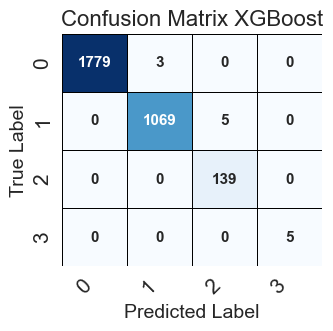

In [18]:
# Simple XGBoost model with conf matrix

import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


xgb_model = xgb.XGBClassifier(
    n_estimators=1,          # Only one boosting round = one tree
    max_depth=3,             # Keep tree small for readability
    learning_rate=1.0,       # Makes the single tree fit directly to data
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42
)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_val)

print(classification_report(y_val, y_pred))

conf_matrix_xgb = confusion_matrix(y_val, y_pred)
labels = [str(c) for c in np.unique(y_train)]

plt.figure(figsize=(3.2, 3.2))
sns.heatmap(
    conf_matrix_xgb,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels,
    cbar=False,
    linewidths=0.6,
    linecolor="black",
    annot_kws={"size": 11, "weight": "bold"}
)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.title("Confusion Matrix XGBoost", fontsize=16, pad=6)
plt.xticks(fontsize=15, rotation=45, ha="right")
plt.yticks(fontsize=15)
plt.tight_layout(pad=0.3)
plt.savefig("confusion_matrix_xgboost.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [19]:
already_converted = False

In [20]:
"""so jetzt wird mit Kanonen auf Spatzen geschossen
Englisch: Now we shoot at sparrows with cannons

we train a mutilayer perceptron
"""
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
# Keep original copies
X_train_origin = X_train.copy()
X_test_origin  = X_val.copy()



# Initialize scaler
scaler = StandardScaler()

# Fit on training data and transform both training and test sets
X_train = scaler.fit_transform(X_train_origin)
X_val  = scaler.transform(X_test_origin)


try:
    already_converted
except NameError:
    already_converted = False
print(already_converted)

if not already_converted:
    y_train = to_categorical(y_train, 4)
    y_test  = to_categorical(y_val, 4)
    already_converted = True


print(y_test.shape)

False
(3000, 4)


In [21]:
"""builds multilayer perceptron we use default density like in the clothing example. Like there we also use relu as activiation function for layer 1 and 2
We have to change input shape though from 784 to 14 """
mlp_model = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=(14,)),  # Hidden layer 1
    layers.Dense(128, activation='relu'),                      # Hidden layer 2
    layers.Dense(4 , activation='softmax')                    # Output layer (4 classes)
])

mlp_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # Use this for integer labels
    metrics=['accuracy']
)


/Users/paulzelaskowski/PycharmProjects/Umea_introduction/.venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
train_history = mlp_model.fit(
    X_train, y_train,
    epochs=20,          # Number of epochs to train the model
    batch_size=128,     # Number of samples per gradient update
    validation_data=(X_val, y_test) )

Epoch 1/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8337 - loss: 0.5417 - val_accuracy: 0.8893 - val_loss: 0.3005
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9073 - loss: 0.2435 - val_accuracy: 0.9273 - val_loss: 0.2075
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9393 - loss: 0.1736 - val_accuracy: 0.9457 - val_loss: 0.1623
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9541 - loss: 0.1323 - val_accuracy: 0.9530 - val_loss: 0.1294
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9661 - loss: 0.1046 - val_accuracy: 0.9607 - val_loss: 0.1092
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9689 - loss: 0.0895 - val_accuracy: 0.9563 - val_loss: 0.1069
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9744 - loss: 0.0750 - val_accuracy: 0.9643 - val_loss: 0.0883
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9771 - loss: 0.0662 - val_accuracy: 0.9623 - val_loss:

In [23]:
test_loss, test_acc = mlp_model.evaluate(X_val, y_test)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step - accuracy: 0.9767 - loss: 0.0535
Test loss: 0.0535
Test accuracy: 0.9767


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step


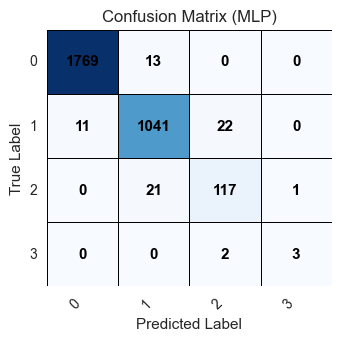

In [24]:
# Get predictions (class indices)
y_pred_probs = mlp_model.predict(X_val)
y_pred_mlp   = np.argmax(y_pred_probs, axis=1)     # convert from one-hot probabilities → class labels

# Get true labels
# If your y_test is one-hot encoded:
if y_test.ndim == 2 and y_test.shape[1] == 4:
    y_true = np.argmax(y_test, axis=1)
else:
    y_true = y_test




conf_matrix_mlp = confusion_matrix(y_true, y_pred_mlp)

plt.figure(figsize=(3.3, 3.3))  # compact and consistent with the others

sns.heatmap(
    conf_matrix_mlp,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels,
    cbar=False,
    linewidths=0.6,
    linecolor="black",
    annot_kws={"size": 11, "weight": "bold", "color": "black"}  # clear, balanced numbers
)

plt.xlabel("Predicted Label", fontsize=11)
plt.ylabel("True Label", fontsize=11)
plt.title("Confusion Matrix (MLP)", fontsize=12, pad=6)
plt.xticks(fontsize=10, rotation=45, ha="right")
plt.yticks(fontsize=10, rotation=0)

plt.tight_layout(pad=0.3)
plt.savefig("confusion_matrix_mlp.pdf", dpi=300, bbox_inches="tight")
plt.show()

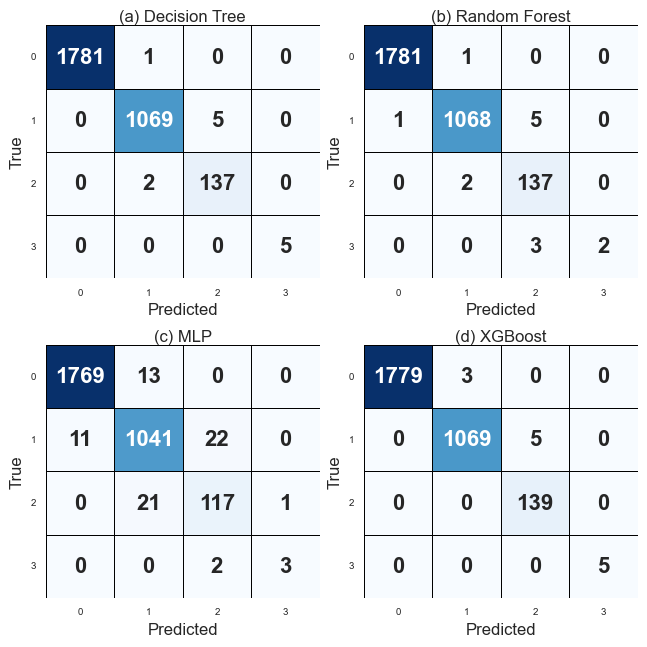

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
#combined figure for the decsion trees
fig, axes = plt.subplots(2, 2, figsize=(6.5, 6.5))  # A4-friendly square layout

conf_matrices = [conf_matrix_tree_naive, conf_matrix_rf, conf_matrix_mlp, conf_matrix_xgb]
titles = [
    "(a) Decision Tree",
    "(b) Random Forest",
    "(c) MLP",
    "(d) XGBoost"
]

for ax, cm, title in zip(axes.flat, conf_matrices, titles):
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=labels,
        yticklabels=labels,
        cbar=False,
        linewidths=0.6,
        linecolor="black",
        annot_kws={"size": 16, "weight": "bold"},
        ax=ax
    )
    ax.set_xlabel("Predicted", fontsize=12)
    ax.set_ylabel("True", fontsize=12)
    ax.set_title(title, fontsize=12, pad=3)
    ax.tick_params(axis='x', labelrotation=0, labelsize=7)
    ax.tick_params(axis='y', labelrotation=0, labelsize=7)

plt.tight_layout(pad=0.8, w_pad=0.6, h_pad=0.8)
plt.savefig("all_confusion_matrices.pdf", dpi=400, bbox_inches="tight")
plt.show()